In [1]:
import datetime
from pprint import pprint

import japanize_matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from stockstats import StockDataFrame

sns.set(font="IPAexGothic", rc={"figure.figsize": (11, 8)})
pd.options.display.float_format = "{:6.2f}".format

/usr/local/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
# Valid start and end: YYYY-MM-DD
# Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
response = yf.download(
    tickers="NDAQ",
    period="5y",
    interval="1d",
    group_by="ticker",
)

[*********************100%***********************]  1 of 1 completed


In [3]:
yfdata = response.copy().dropna()
# yfdata = yfdata["1950-01":"202１-12"]  # 直近の暴落を除いて検証する
yfdata

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-05-30,67.48,67.71,67.20,67.42,61.90,618900
2017-05-31,67.68,68.06,67.29,67.65,62.11,1148300
2017-06-01,68.05,68.13,67.38,67.87,62.31,699400
2017-06-02,68.02,68.02,67.37,67.50,61.97,521800
2017-06-05,67.51,68.48,67.51,67.87,62.31,605100
...,...,...,...,...,...,...
2022-05-23,147.45,148.44,145.72,147.71,147.71,828200
2022-05-24,146.43,147.26,144.10,146.63,146.63,779600
2022-05-25,146.22,148.39,145.70,147.50,147.50,879900


In [4]:
def convert_df_to_stock_df(df: pd.DataFrame) -> StockDataFrame:
    sdf = df.copy()
    sdf.rename(
        columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Adj Close": "amount",
            "Volume": "volume",
        },
        inplace=True,
    )
    sdf.index.names = ["date"]
    return StockDataFrame(sdf)


def MACD(arr: pd.DataFrame) -> tuple[pd.Series, pd.Series]:
    sdf = convert_df_to_stock_df(arr)
    StockDataFrame.MACD_EMA_SHORT = 12
    StockDataFrame.MACD_EMA_LONG = 26
    StockDataFrame.MACD_EMA_SIGNAL = 9
    return (sdf["macd"], sdf["macds"])


def RSI(arr: pd.DataFrame, rsi: int) -> pd.Series:
    sdf = convert_df_to_stock_df(arr)
    return sdf["rsi_" + str(rsi)]


# 週足に変換する
def day_2_week(pd: pd.DataFrame) -> pd.DataFrame:
    return (
        pd.copy()
        .resample("W")
        .agg(
            {
                "Open": "first",
                "High": "max",
                "Low": "min",
                "Close": "last",
                "Volume": "sum",
            }
        )
    )

In [5]:
def macd_week(data: pd.DataFrame) -> tuple[pd.Series, pd.Series]:
    m, s = MACD(day_2_week(yfdata))
    df = pd.concat([data.copy(), pd.DataFrame([m, s]).transpose()], axis=1)

    tmp_macd = 0
    tmp_macds = 0

    for index, row in df.iterrows():
        if pd.isna(row["macd"]) or pd.isna(row["macds"]):
            df.at[index, "macd"] = tmp_macd
            df.at[index, "macds"] = tmp_macds
        else:
            tmp_macd = row["macd"]
            tmp_macds = row["macds"]

    df = df.dropna()
    return (df["macd"], df["macds"])

In [6]:
class My_Strategy(Strategy):
    # RSI
    prop_rsi = 7  # 14
    prop_rsi_high = 80  # 70
    prop_rsi_low = 20  # 30

    def init(self):
        self.macd, self.macd_signal = self.I(MACD, self.data.df)

        self.week_macd, self.week_signal = self.I(macd_week, self.data.df)

        self.rsi = self.I(RSI, self.data.df, self.prop_rsi)

    def next(self):
        # 計算できていない場合トレードしない
        if len(self.data.index) < 7 * 26:  # MACD週足の計算に必要な日数
            return

        # 週足MACDのトレンドが変更したら、ポジションを終了する
        if crossover(self.week_macd, self.week_signal) or crossover(
            self.week_signal, self.week_macd
        ):
            self.position.close()

        # # MACDのシグナルが弱い時はダマシの可能性があるので、トレードしない
        # if (-1 <= self.macd[-1] and self.macd[-1] <= 1) and (
        #     -1 <= self.macd_signal[-1] and self.macd_signal[-1] <= 1
        # ):
        #     return

        # 週足MACD上昇トレンド
        if self.week_macd[-1] > self.week_signal[-1]:
            # ゴールデンクロス
            if crossover(self.macd, self.macd_signal) or crossover(
                self.week_macd, self.week_signal
            ):
                self.buy()
                return

            # デッドクロス
            if crossover(self.macd_signal, self.macd):
                self.position.close()
                return

            if self.prop_rsi_low > self.rsi[-1]:
                self.buy()
                return

            if self.prop_rsi_high < self.rsi[-1]:
                self.position.close()
                return

        # 週足MACD下降トレンド
        if self.week_macd[-1] < self.week_signal[-1]:
            if crossover(self.macd_signal, self.macd) or crossover(
                self.week_signal, self.week_macd
            ):
                self.sell()
                return

            if crossover(self.macd, self.macd_signal):
                self.position.close()
                return

            if self.prop_rsi_high < self.rsi[-1]:
                self.sell()
                return

            if self.prop_rsi_low > self.rsi[-1]:
                self.position.close()
                return


bt = Backtest(yfdata, My_Strategy, cash=10000, commission=0.002, exclusive_orders=True)


# 最適化
# optimize = bt.optimize(
#     prop_rsi=range(5, 100, 1),
#     method="grid",  # unuse model-based optimization
#     # constraint=lambda p: p.prop_rsi_low < p.prop_rsi_high,
#     maximize="Equity Final [$]",
# )

# bt.plot()
# print(optimize)
# print(optimize._strategy)


# 出力
output = bt.run()

print("Return : " + str(output["Return [%]"]) + "%")
print("Trades : " + str(output["# Trades"]))
# print(output)

# print(output["_trades"])
bt.plot()

Return : 61.69363708465567%
Trades : 65


Row(id='1647', ...)

<Figure size 792x576 with 0 Axes>

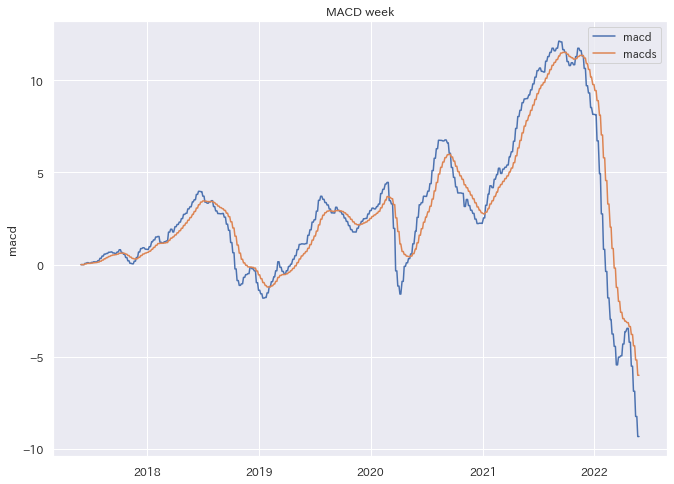

<Figure size 792x576 with 0 Axes>

In [7]:
macd, macds = macd_week(yfdata)

plot_df = pd.concat([yfdata.copy(), pd.DataFrame([macd, macds]).transpose()], axis=1)
plot_df

sns.lineplot(data=plot_df, x=plot_df.index, y="macd").set_title("MACD week")
sns.lineplot(data=plot_df, x=plot_df.index, y="macds")
plt.legend(labels=["macd", "macds"])
plt.figure()